In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import

In [2]:
from collections import OrderedDict
import numpy
import pandas

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier

In [3]:
from utils import get_N_B_events, predict_by_estimator, bootstrap_calibrate_prob
from utils import get_events_number, get_events_statistics, result_table, compute_mistag, shrink_floats_xgb

## Reading initial data

In [9]:
import root_numpy
def read_samples(filename, filename_vtx):
    datasets = dict()
    for name, selection, f in zip(['K', 'e', 'mu', 'vtx'], 
                                  ['K_cut == 1', 'e_cut == 1', 'mu_cut == 1', '(v_cut == 1) & (vcharge > 0.2)'],
                                  [filename] * 3 + [filename_vtx]):
        data = pandas.DataFrame(root_numpy.root2array(f, selection=selection))                       
        shrink_floats_xgb(data)        
        if name == 'vtx':
            data['label'] = (data.signB.values * data.signVtx.values < 0) * 1
        else:
            data['label'] = (data.signB.values * data.signTrack.values < 0) * 1
        data['event_id'] = data.run.apply(str) + '_' + data.event.apply(str)
        data['tagAnswer'] = data.signB * (2 * data.label - 1)
        data['N_sig_sw'] = 1.
        datasets[name] = data
    
    return datasets

In [11]:
def compute_efficiencies(datasets, N_B_events):
    result = dict()
    for key, data in datasets.items():
        N_B_passed = get_events_number(data)
        result[key] = (1. * N_B_passed / N_B_events, sqrt(N_B_passed) / N_B_events)
    return result

In [10]:
datasets = read_samples('datasets/MC/csv/Bu_JPsiK/Tracks.root', 'datasets/MC/csv/Bu_JPsiK/Vertices.root')

In [12]:
datasets_kstar = read_samples('datasets/MC/csv/Bd_JPsiKstar/Tracks.root', 'datasets/MC/csv/Bd_JPsiKstar/Vertices.root')
datasets_ks = read_samples('datasets/MC/csv/Bd_JPsiKs/Tracks.root', 'datasets/MC/csv/Bd_JPsiKs/Vertices.root')

## Calculate $\epsilon_{tag}$ for each datasets

In [14]:
N_B_events = 1488891.0
N_B_events_kstar = 431667.0
N_B_events_ks = 130875.0

In [15]:
eff = compute_efficiencies(datasets, N_B_events)
eff_kstar = compute_efficiencies(datasets_kstar, N_B_events_kstar)
eff_ks = compute_efficiencies(datasets_ks, N_B_events_ks)

In [18]:
print 'K+-'
print pandas.DataFrame(eff)
print 'K*'
print pandas.DataFrame(eff_kstar)
print 'Ks'
print pandas.DataFrame(eff_ks)

K+-
          K         e        mu       vtx
0  0.177597  0.020230  0.050538  0.098330
1  0.000345  0.000117  0.000184  0.000257
K*
          K         e        mu       vtx
0  0.179499  0.020657  0.050497  0.099681
1  0.000645  0.000219  0.000342  0.000481
Ks
          K         e        mu       vtx
0  0.173906  0.019698  0.049352  0.097261
1  0.001153  0.000388  0.000614  0.000862


## Features used in training

In [19]:
features_vtx = ['mult', 'nnkrec', 'log_ptB: log(ptB)', 'vflag', 'log_ipsmean: log(ipsmean)', 
                'log_ptmean: log(ptmean)', 'vcharge', 
                'log_svm: log(svm)', 'log_svp: log(svp)', 'BDphiDir', 'log_svtau: log(svtau)', 'docamax']

features_ele = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'log_eOverP: log(EOverP)', 
                'ghostProb', 'log_IPPU: log(IPPU)']
features_muon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'PIDNNm', 'ghostProb', 'log_IPPU: log(IPPU)']
features_kaon = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
                 'nnkrec','log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'log_IPPU: log(IPPU)']
                                    
features = {'e': features_ele, 'mu': features_muon,
            'K': features_kaon, 'vtx': features_vtx}

# features_tr = ['mult', 'log_partPt: log(partPt)', 'log_partP: log(partP)',
#                'log_ptB: log(ptB)', 'log_IPs: log(IPs)', 'partlcs', 'ghostProb', 'log_IPPU: log(IPPU)', 
#                'log_EOverP: log(EOverP)', 
#                'PIDNNpi', 'PIDNNp', 'PIDNNk', 'PIDNNm', 'PIDNNe', 'nnkrec', 'log_partTheta: log(partTheta)',
#                'log_partPhi: log(partPhi)', 'veloch']

In [22]:
estimators = OrderedDict()

### XGBoost

In [23]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base_ele = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                                 n_estimators=200, subsample=0.3, max_depth=5) 

xgb_base_other = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                                   n_estimators=500, subsample=0.3, max_depth=3) 

for key, data in datasets.items():
    if 'e' in key:
        xgb_base = xgb_base_ele
    else:
        xgb_base = xgb_base_other
        
    estimators[key + '_xgboost'] = FoldingClassifier(xgb_base, n_folds=2, random_state=11, parallel_profile='ssh-py2',
                                                     features=features[key])
    estimators[key + '_xgboost'].fit(data, data['label'], data['N_sig_sw'])

### TMVA

In [24]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', TestRate=5,
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I,D,N', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for key, data in datasets.items():
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=11, parallel_profile='ssh-py2',
                                                  features=features[key])
    estimators[key + '_tmva'].fit(data, data['label'], data['N_sig_sw'])

In [25]:
# import cPickle
# with open('models/old-tagging-MC.pkl', 'r') as f:
#     estimators = cPickle.load(f)

In [26]:
import cPickle
with open('models/old-tagging-MC.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [28]:
estimators.keys()

['mu_xgboost',
 'vtx_xgboost',
 'K_xgboost',
 'e_xgboost',
 'mu_tmva',
 'vtx_tmva',
 'K_tmva',
 'e_tmva']

In [29]:
for key in datasets.keys():
    for suffix in ['_xgboost', '_tmva']:
        name = key + suffix
        for data, label in zip([datasets[key], datasets_kstar[key], datasets_ks[key]],
                               ['K+-', 'K*', 'Ks']):
            probs = estimators[name].predict_proba(data)[:, 1]        
            print name, label, 'AUC:', roc_auc_score(data['label'].values, 
                                                     probs, sample_weight=data['N_sig_sw'].values)

KFold prediction using folds column
mu_xgboost K+- AUC: 0.602239696051
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost K* AUC: 0.611715151984
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_xgboost Ks AUC: 0.60907181786
KFold prediction using folds column
mu_tmva K+- AUC: 0.592810717311
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva K* AUC: 0.598372122464
KFold prediction using random classifier (length of data passed not equal to length of train)
mu_tmva Ks AUC: 0.607212728002
KFold prediction using folds column
vtx_xgboost K+- AUC: 0.590494206064
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost K* AUC: 0.588902485519
KFold prediction using random classifier (length of data passed not equal to length of train)
vtx_xgboost Ks AUC: 0.583921153158
KFold prediction using fol

--------

## Calculate quality for each tagger (ele, muon, kaon, vtx)

using isotonic final calibration with bootstrap

In [137]:
from utils import predict_by_estimator, calibrate_probs, run_taggers_combination

def combine(estimators, datasets, keys, N_B_events, logistic=False,
            return_calibrations=False, logistic_combined=True, model_name=None, with_roc=False):
    """
    :param suffix: suffix used for taggers
    :param model_name: name for model after combining classifiers
    """
    data_with_predictions = {}
    calibrators_tracks = dict()
    
    # computing calibrated predictions of each tagger
    for key in keys:
        data, probs = predict_by_estimator(estimators[key], [datasets[key]])
        probs_calibrated, calibrators_tracks[key] = \
            calibrate_probs(data.label.values, data.N_sig_sw.values, probs, logistic=logistic)
            
        ids = numpy.array(data['event_id'])
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                       'tag_{}'.format(key): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids)
        
    calibrator_B, table, roc = run_taggers_combination(data_with_predictions, keys, N_B_events, 
                                                       model_name=','.join(keys) if model_name is None else model_name, 
                                                       logistic_combined=logistic_combined)
    if return_calibrations and with_roc:
        return table, calibrators_tracks, calibrator_B, roc
    elif return_calibrations and not with_roc:
        return table, calibrators_tracks, calibrator_B
    elif with_roc:
        return table, roc
    else:
        return table

### TMVA

In [106]:
test_estimators_tmva = dict((key, estimators[key + '_tmva']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.726294002565 AUC with untag: 0.518444925626


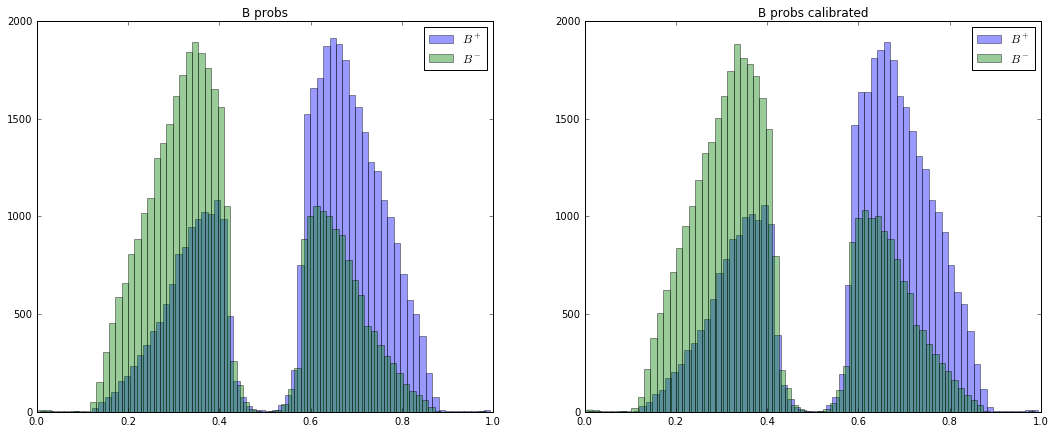

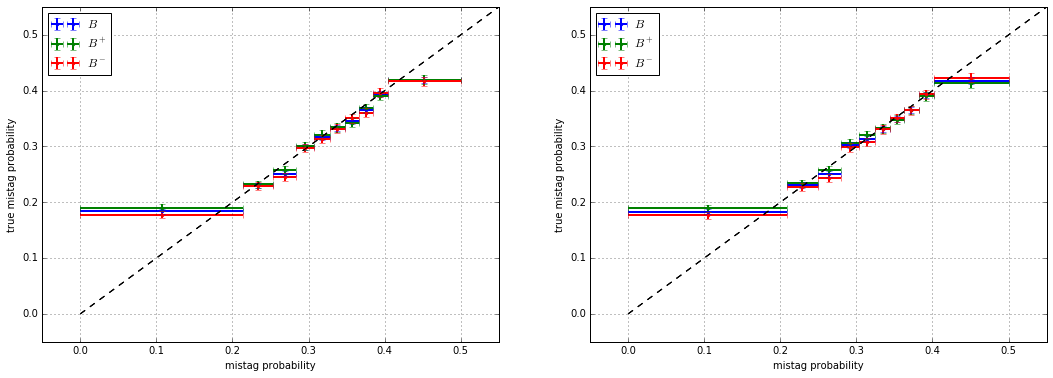

Efficiency, not calibrated 0.771571415379
Average AUC 0.726258061515 5.51736024479e-05
KFold prediction using folds column
AUC for tagged: 0.673776982513 AUC with untag: 0.528694626101


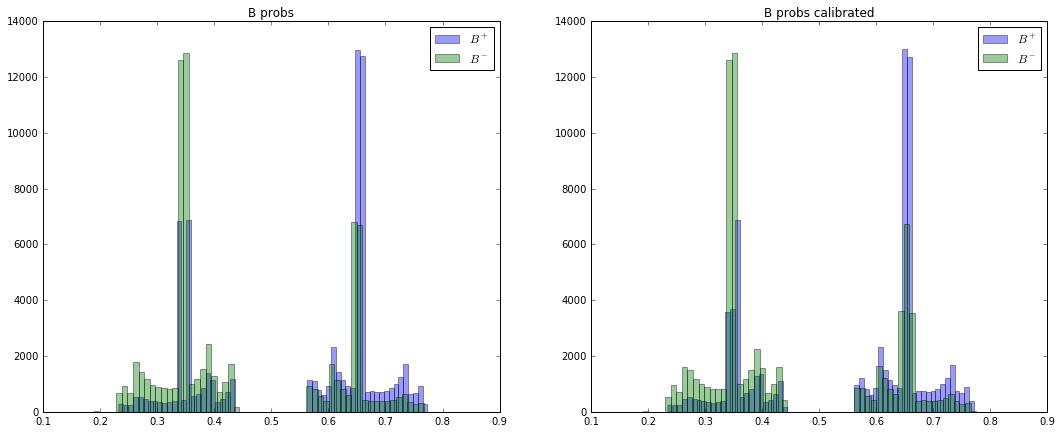

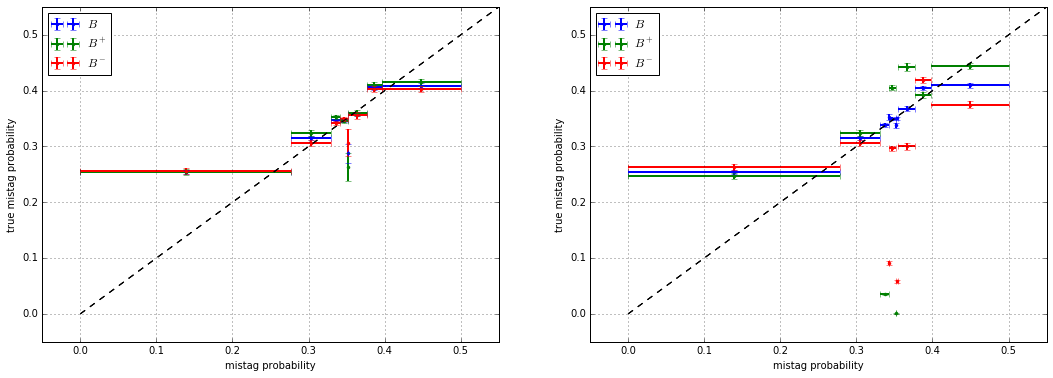

Efficiency, not calibrated 1.00856656795
Average AUC 0.673726322257 0.000112627376603
KFold prediction using folds column
AUC for tagged: 0.682218855162 AUC with untag: 0.551450404381


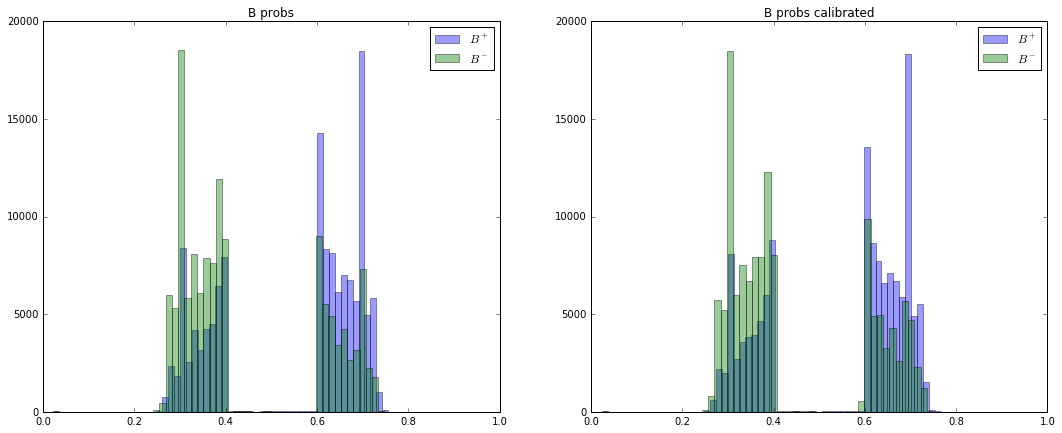

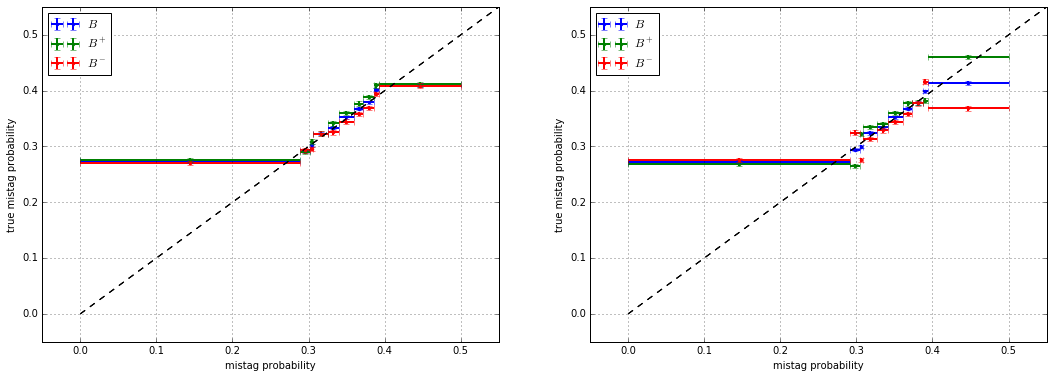

Efficiency, not calibrated 1.9075444489
Average AUC 0.682155018745 6.34386264479e-05
KFold prediction using folds column
AUC for tagged: 0.694102828028 AUC with untag: 0.506600082849


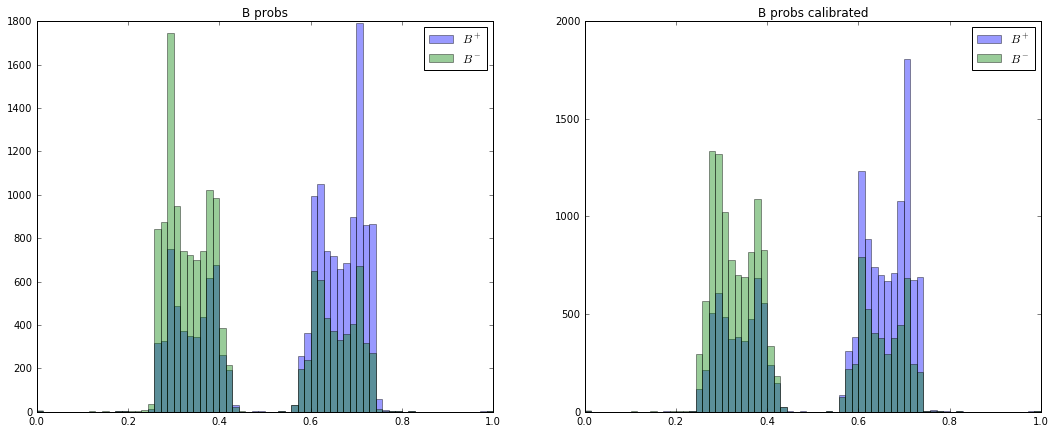

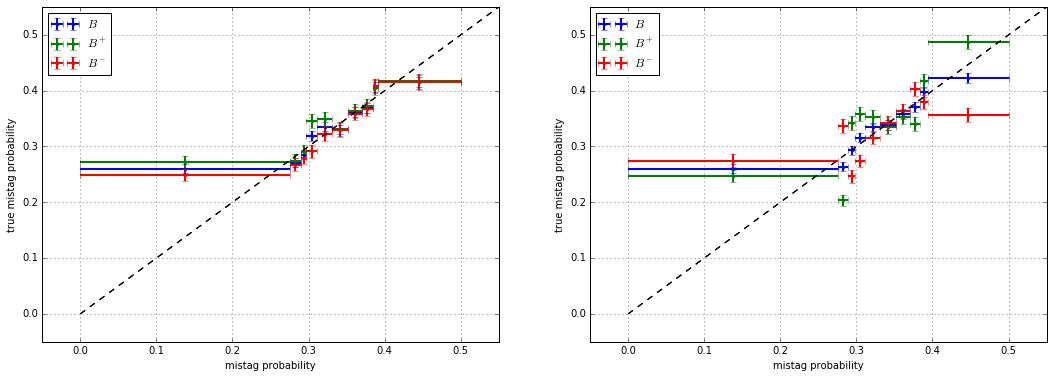

Efficiency, not calibrated 0.24048742009
Average AUC 0.693885580878 0.00020830280802


In [107]:
figsize(18, 7)

results_separate_tmva = []
for key in datasets.keys(): 
    x = combine(test_estimators_tmva, datasets, [key], N_B_events, logistic=True)
    results_separate_tmva.append(x)

In [108]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.157817,0.001218,0.797582,0.006806,51.844493,0
0,vtx,9.832956,0.025699,0.099798,0.000534,0.981306,0.005847,52.869463,0
0,K,17.759661,0.034537,0.105741,0.000404,1.877932,0.008050,55.145040,0
0,e,2.023049,0.011657,0.117104,0.001364,0.236908,0.003079,50.660008,0


### XGBoost

In [109]:
test_estimators = dict((key, estimators[key + '_xgboost']) for key in ['K', 'mu', 'e', 'vtx'])

KFold prediction using folds column
AUC for tagged: 0.730328789563 AUC with untag: 0.518414417192


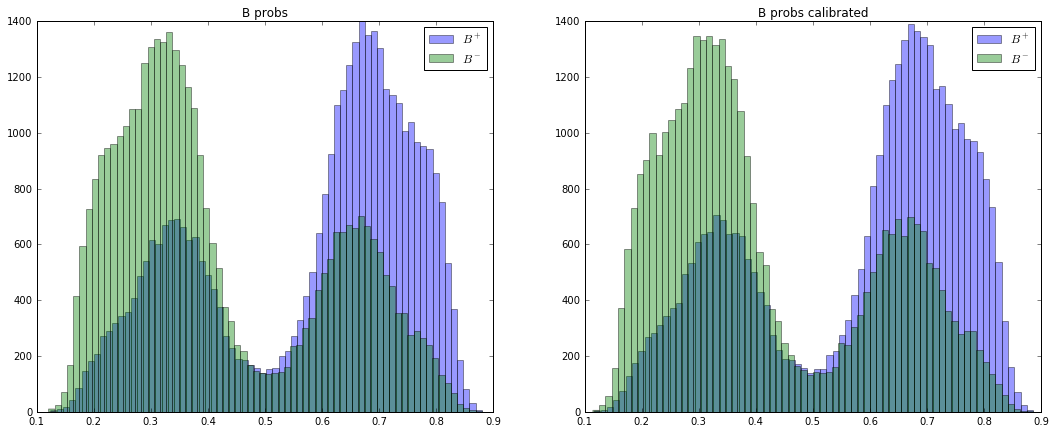

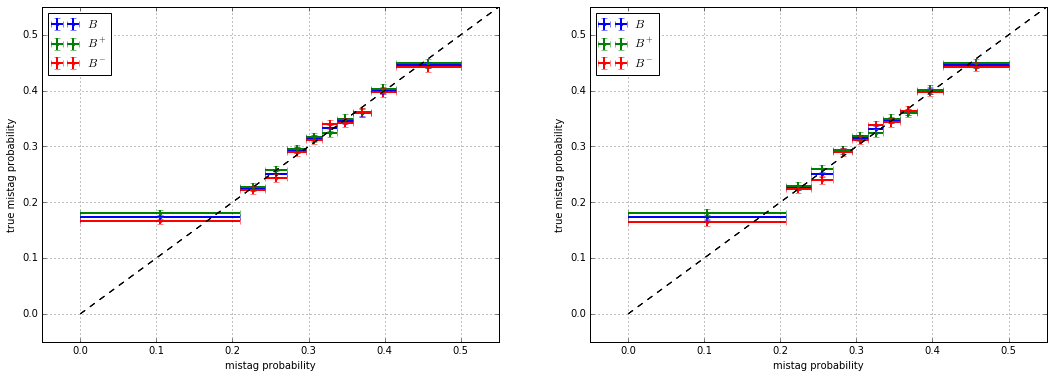

Efficiency, not calibrated 0.805685770783
Average AUC 0.730294644495 5.3772223501e-05
KFold prediction using folds column
AUC for tagged: 0.693299908523 AUC with untag: 0.528729549524


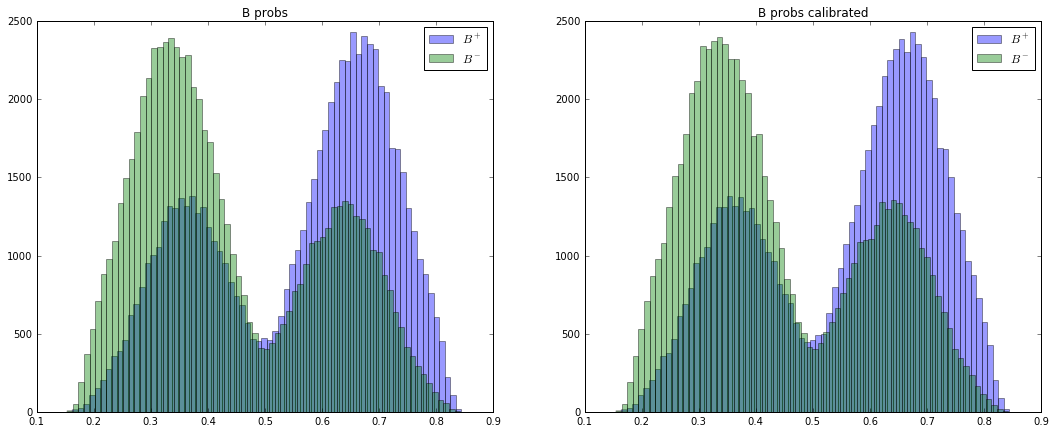

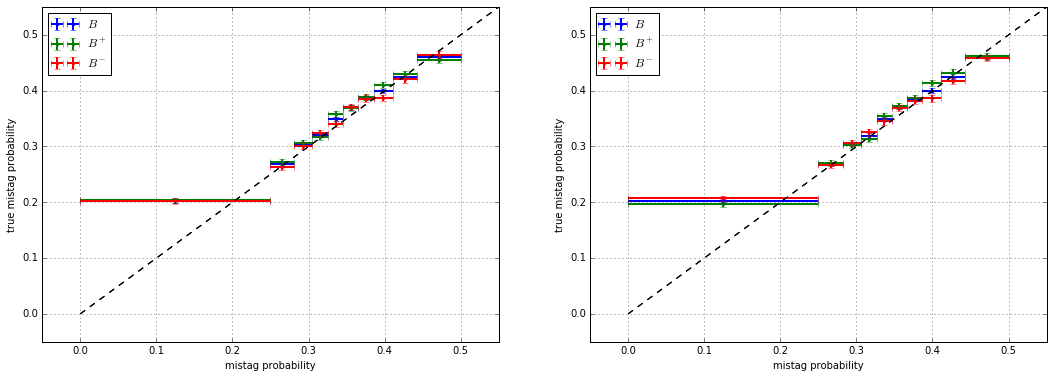

Efficiency, not calibrated 1.14152767089
Average AUC 0.693279519383 2.02181175755e-05
KFold prediction using folds column
AUC for tagged: 0.690358897714 AUC with untag: 0.551662943373


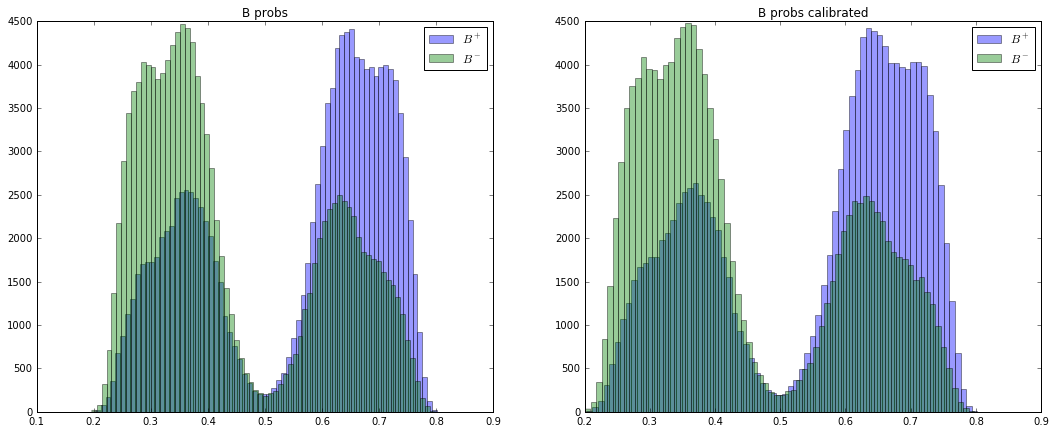

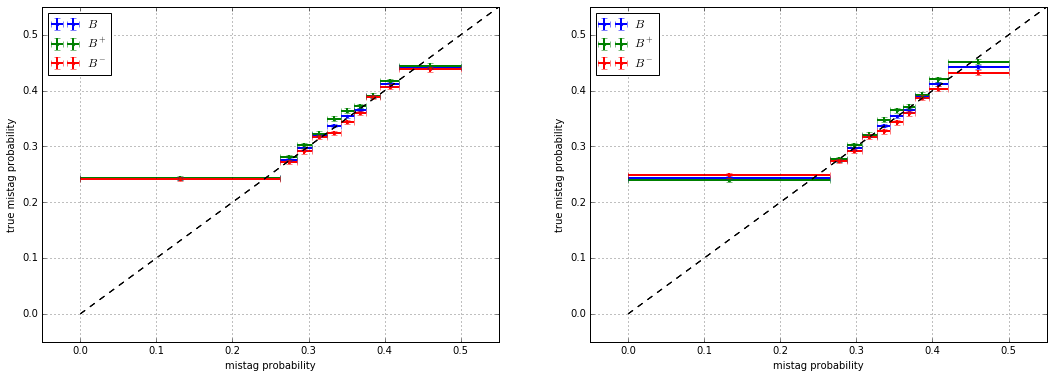

Efficiency, not calibrated 2.02711071742
Average AUC 0.690342017255 2.28217633084e-05
KFold prediction using folds column
AUC for tagged: 0.704114606952 AUC with untag: 0.506591018935


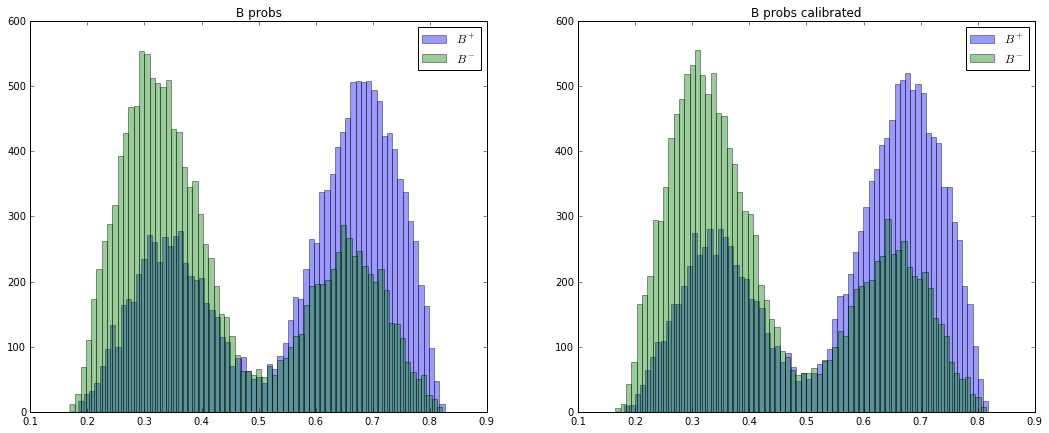

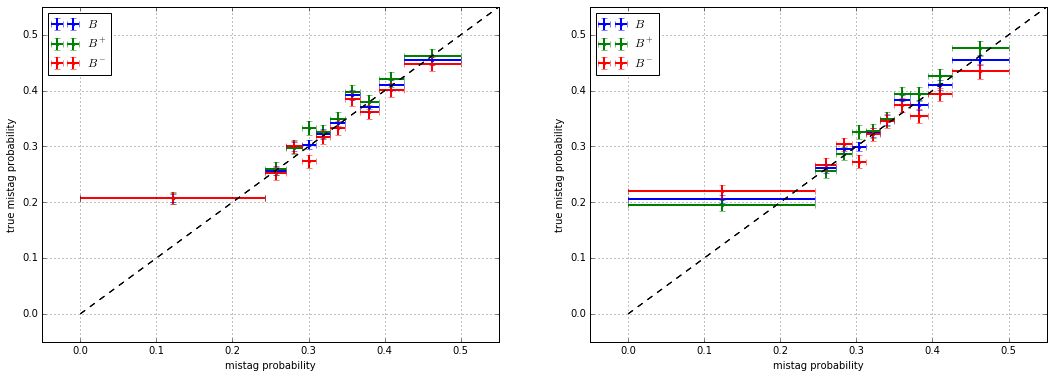

Efficiency, not calibrated 0.266113883938
Average AUC 0.704007565081 0.000128596248593


In [110]:
figsize(18, 7)

calibrators_B = dict()
calibrator_tracks = dict()

results_separate = []
for key in datasets.keys(): 
    x, calibrator_tracks[key], calibrators_B[key] = combine(test_estimators, datasets, [key], N_B_events,
                                                            logistic=True, return_calibrations=True)
    results_separate.append(x)

In [111]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162609,0.001427,0.821796,0.007811,51.841442,0
0,vtx,9.832956,0.025699,0.113994,0.000656,1.120896,0.007088,52.872955,0
0,K,17.759661,0.034537,0.111915,0.000421,1.987573,0.008412,55.166294,0
0,e,2.023049,0.011657,0.128254,0.001450,0.259464,0.003293,50.659102,0


## test individuals taggers on K* and Ks

In [115]:
# reload(utils)
from utils import estimate_new_data_old_scheme

### K*

K
KFold prediction using random classifier (length of data passed not equal to length of train)


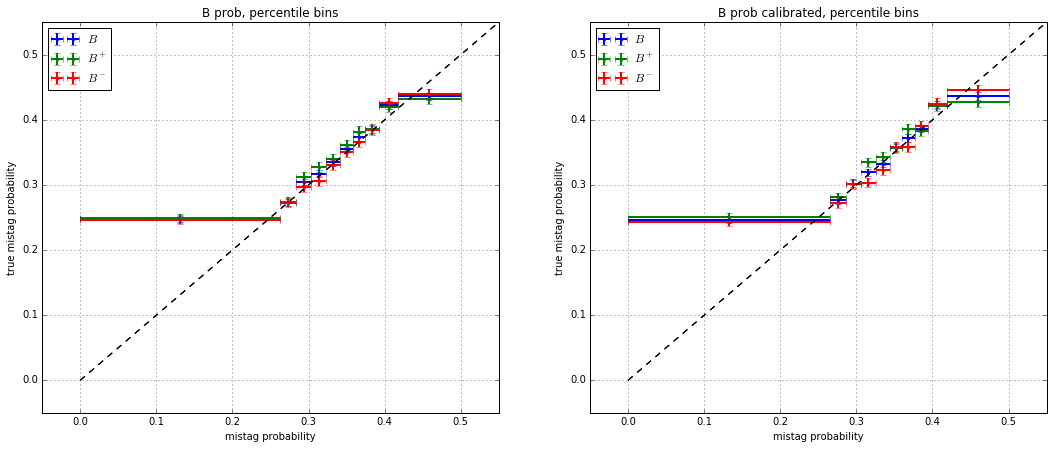

e
KFold prediction using random classifier (length of data passed not equal to length of train)


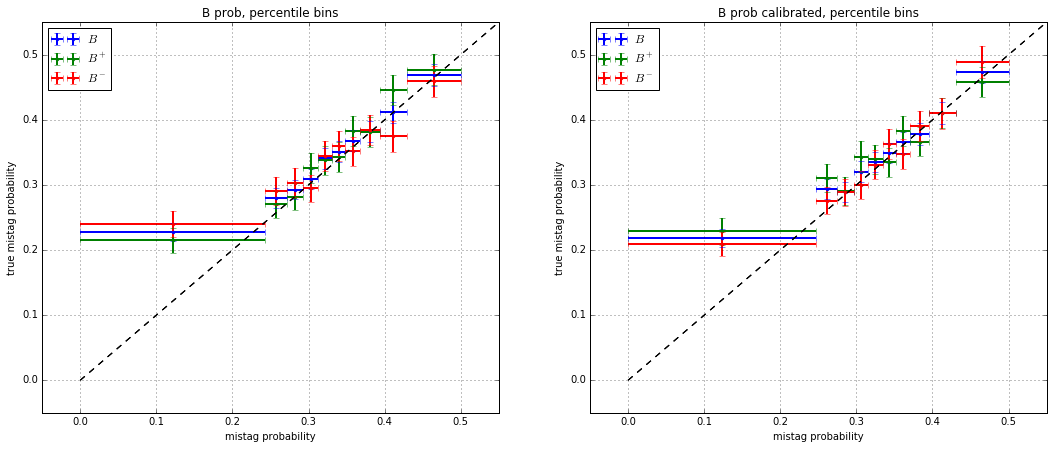

mu
KFold prediction using random classifier (length of data passed not equal to length of train)


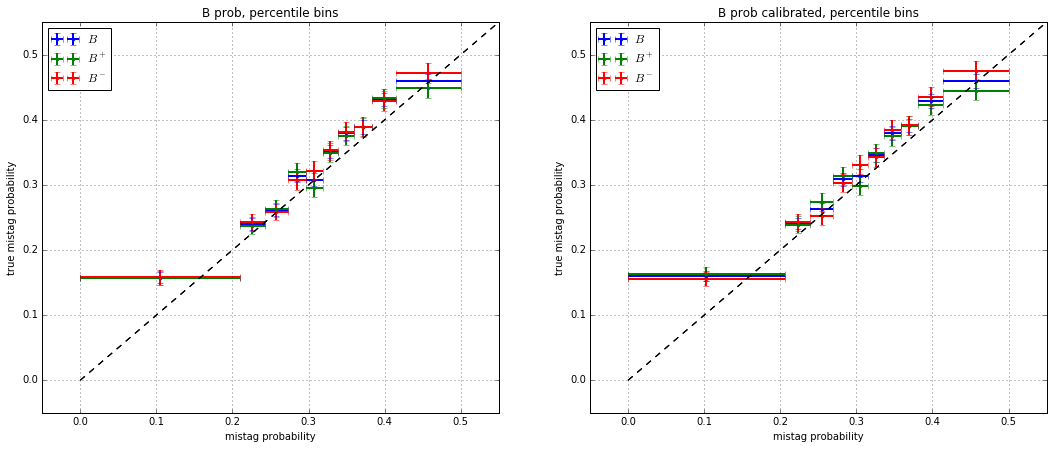

In [116]:
results_separate_kstar = []

for key in ['K', 'e', 'mu']:
    print key
    x = estimate_new_data_old_scheme(test_estimators, datasets_kstar, [key],
                                     calibrator_tracks[key], calibrators_B[key], 
                                     N_B_events_kstar, model_name='K* ' + key)
    results_separate_kstar.append(x)

### Ks

K
KFold prediction using random classifier (length of data passed not equal to length of train)


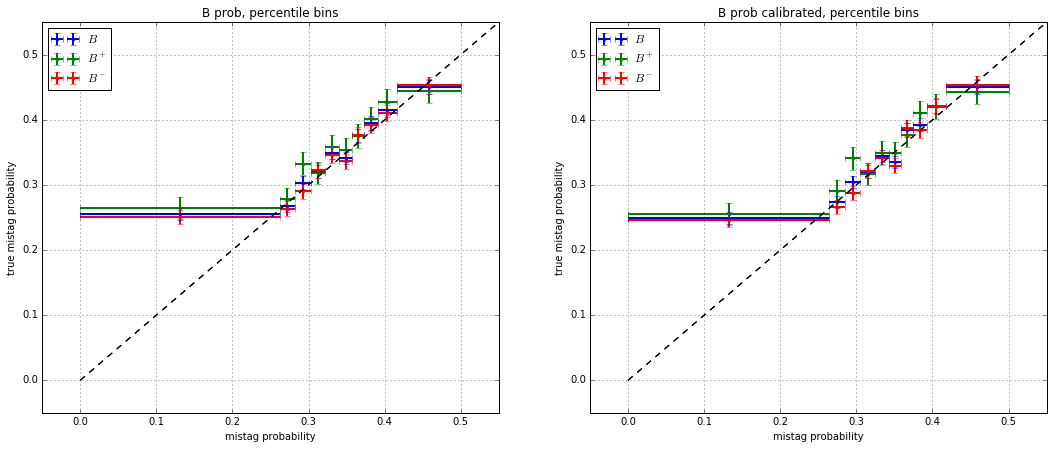

e
KFold prediction using random classifier (length of data passed not equal to length of train)


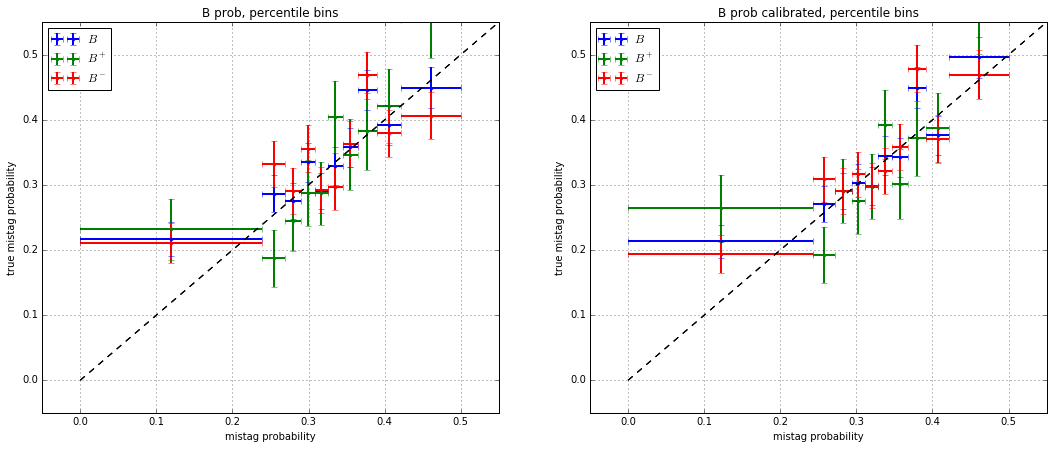

mu
KFold prediction using random classifier (length of data passed not equal to length of train)


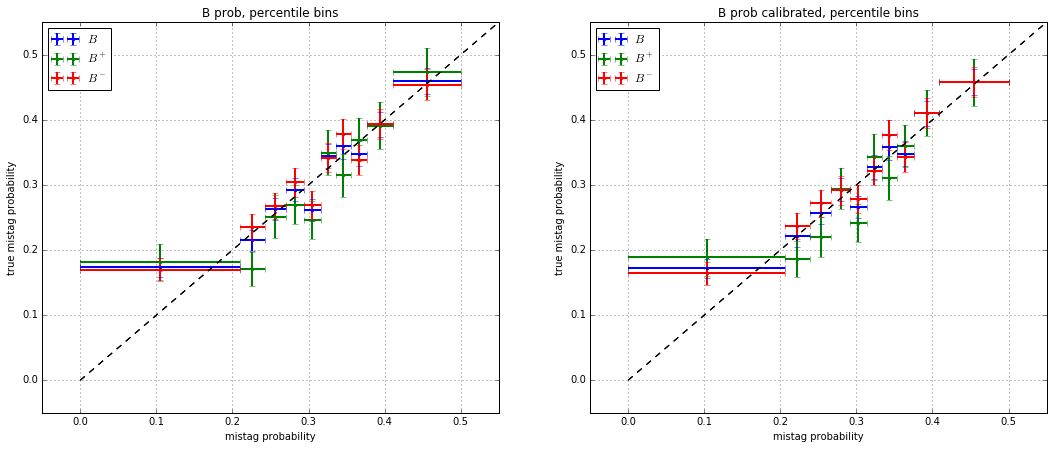

In [117]:
results_separate_ks = []

for key in ['K', 'e', 'mu']:
    print key
    x = estimate_new_data_old_scheme(test_estimators, datasets_ks, [key],
                                     calibrator_tracks[key], calibrators_B[key], 
                                     N_B_events_ks, model_name='Ks ' + key)
    results_separate_ks.append(x)

In [119]:
pandas.concat(results_separate_kstar + results_separate_ks)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* K,17.949948,0.064485,0.112370,0,2.017042,0.007246,55.167869,0
0,K* e,2.065713,0.021876,0.125726,0,0.259714,0.002750,50.642430,0
0,K* mu,5.049726,0.034203,0.162779,0,0.821992,0.005567,51.694069,0
0,Ks K,17.390640,0.115273,0.113747,0,1.978129,0.013112,54.873821,0
0,Ks e,1.969819,0.038796,0.130716,0,0.257487,0.005071,50.633038,0
0,Ks mu,4.935244,0.061408,0.166609,0,0.822258,0.010231,51.823214,0


# Combination of all taggers

### TMVA

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.698333907222 AUC with untag: 0.569202425315


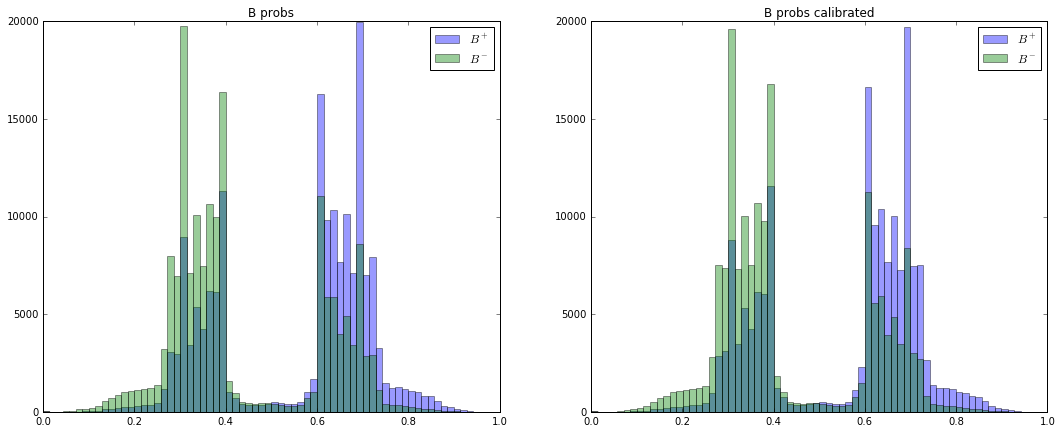

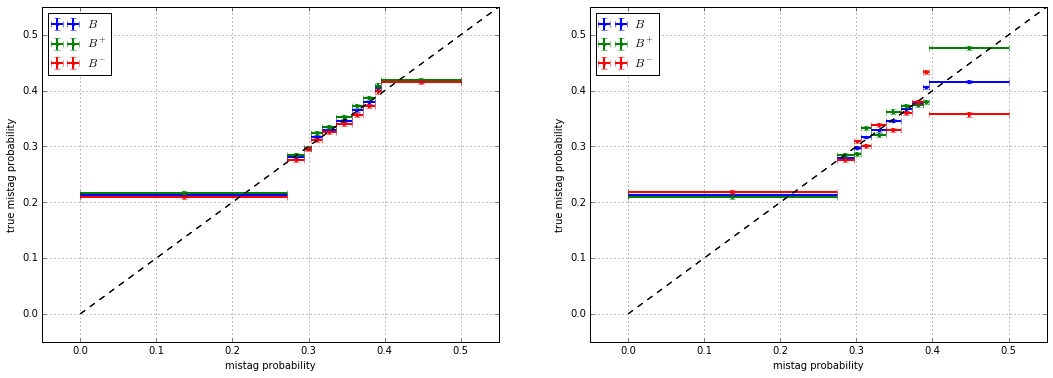

Efficiency, not calibrated 2.89307701333
Average AUC 0.698315639352 1.67653471019e-05


In [121]:
figsize(18, 7)

results_separate_tmva.append(combine(test_estimators_tmva, datasets, ['K', 'e', 'mu'], N_B_events, logistic=True,
                                     model_name='tmva combination'))

### XGBoost

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.705546880468 AUC with untag: 0.569637870793


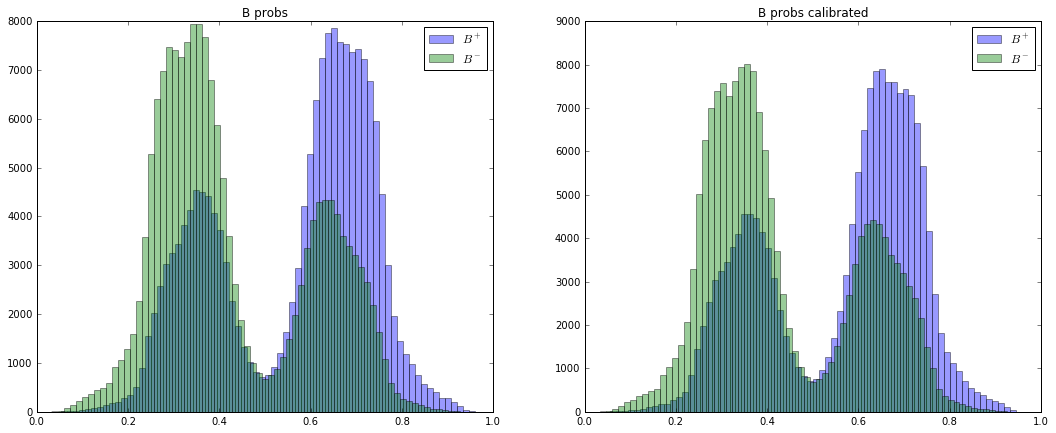

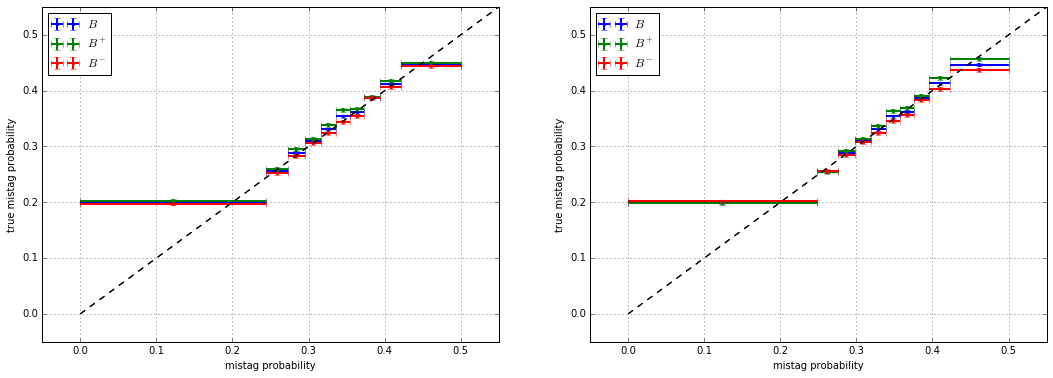

Efficiency, not calibrated 3.06427705932
Average AUC 0.705541973879 5.53697876797e-06


In [139]:
figsize(18, 7)

x, calibrator_tracks_comb, calibrator_B_comb, roc_curve_old = combine(test_estimators, datasets, 
                                                                      ['K', 'e', 'mu'], N_B_events,
                                                                      logistic=True, return_calibrations=True,
                                                                      model_name='xgboost combination', with_roc=True)
results_separate.append(x)

In [124]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162609,0.001427,0.821796,0.007811,51.841442,0
0,vtx,9.832956,0.025699,0.113994,0.000656,1.120896,0.007088,52.872955,0
0,K,17.759661,0.034537,0.111915,0.000421,1.987573,0.008412,55.166294,0
0,e,2.023049,0.011657,0.128254,0.001450,0.259464,0.003293,50.659102,0
0,xgboost combination,23.098803,0.039388,0.129372,0.000504,2.988329,0.012711,56.963787,0


## Test combination of taggers on K* and Ks

### K*

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


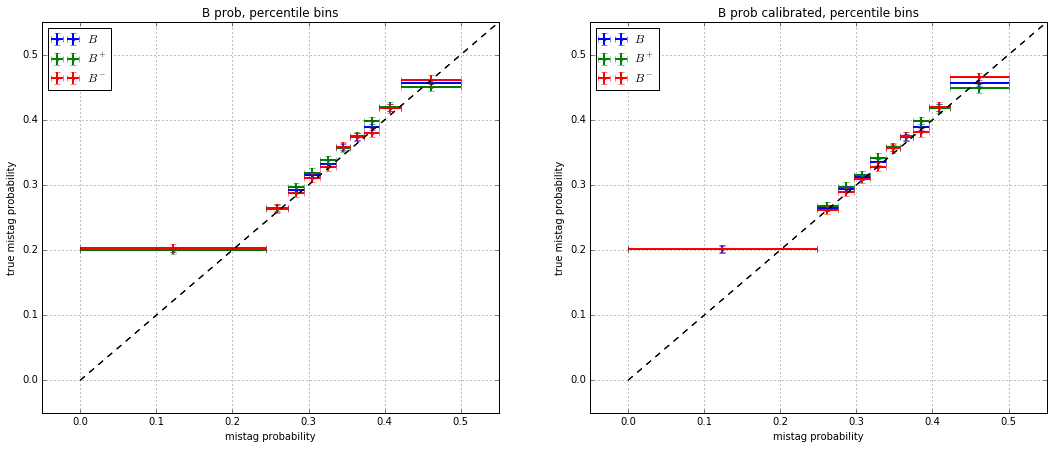

In [127]:
x = estimate_new_data_old_scheme(test_estimators, datasets_kstar, ['K', 'e', 'mu'],
                                 calibrator_tracks_comb, calibrator_B_comb, N_B_events_kstar, 
                                 model_name='K* combination')
results_separate_kstar.append(x)

### Ks

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


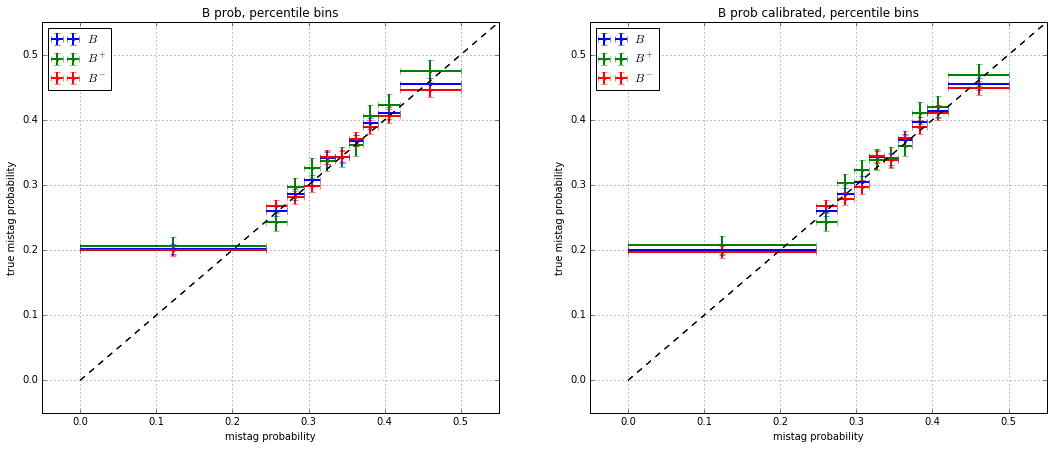

In [128]:
x = estimate_new_data_old_scheme(test_estimators, datasets_ks, ['K', 'e', 'mu'],
                                 calibrator_tracks_comb, calibrator_B_comb, N_B_events_ks, 
                                 model_name='Ks combination')
results_separate_ks.append(x)

# Final results

### TMVA

In [134]:
pandas.concat(results_separate_tmva)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.157817,0.001218,0.797582,0.006806,51.844493,0
0,vtx,9.832956,0.025699,0.099798,0.000534,0.981306,0.005847,52.869463,0
0,K,17.759661,0.034537,0.105741,0.000404,1.877932,0.008050,55.145040,0
0,e,2.023049,0.011657,0.117104,0.001364,0.236908,0.003079,50.660008,0
0,tmva combination,23.098803,0.039388,0.122738,0.000459,2.835108,0.011661,56.920243,0


### XGBoost

In [132]:
pandas.concat(results_separate)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,mu,5.053829,0.018424,0.162609,0.001427,0.821796,0.007811,51.841442,0
0,vtx,9.832956,0.025699,0.113994,0.000656,1.120896,0.007088,52.872955,0
0,K,17.759661,0.034537,0.111915,0.000421,1.987573,0.008412,55.166294,0
0,e,2.023049,0.011657,0.128254,0.001450,0.259464,0.003293,50.659102,0
0,xgboost combination,23.098803,0.039388,0.129372,0.000504,2.988329,0.012711,56.963787,0


In [130]:
pandas.concat(results_separate_kstar)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* K,17.949948,0.064485,0.112370,0,2.017042,0.007246,55.167869,0
0,K* e,2.065713,0.021876,0.125726,0,0.259714,0.002750,50.642430,0
0,K* mu,5.049726,0.034203,0.162779,0,0.821992,0.005567,51.694069,0
0,K* combination,23.294577,0.073460,0.129383,0,3.013930,0.009505,56.803435,0


In [131]:
pandas.concat(results_separate_ks)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks K,17.390640,0.115273,0.113747,0,1.978129,0.013112,54.873821,0
0,Ks e,1.969819,0.038796,0.130716,0,0.257487,0.005071,50.633038,0
0,Ks mu,4.935244,0.061408,0.166609,0,0.822258,0.010231,51.823214,0
0,Ks combination,22.615473,0.131454,0.130891,0,2.960160,0.017206,56.650280,0


In [135]:
pandas.concat(results_separate_tmva + results_separate + results_separate_kstar + results_separate_ks).to_csv(
    'img/old-tagging-MC.csv', header=True, index=False)

In [140]:
import cPickle
with open('models/old-rocs-MC', 'w') as f:
    cPickle.dump(roc_curve_old, f)